## Modeling (Baseline Model and Model Training)

After having done the initial EDA in the previous notebook, we move now to the part of modeling. As already stated in the EDA notebook, due to the huge amount of data and the various hdd models, we start by working on a model solely for the Seagate ST4000DM000.

While our code is aimed to allow reproducibility for any other hard drive model, this model is the focus of this notebook.

Before we start training machine learning algorithm, we construct our baseline model, which we derive based on the important features derived in the last notebook.

After this we try some standard classification and regression models. First solely on the features deemed important for the baseline model and then extent/create new features.

We also use MLFlow to track our "experiments" and use this function to track our baseline model, as well as the machine learning models which are trained after this.

As usual we start by importing relevant libraries.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import mlflow

# define the sys.path for importing the load_preprocess_data function
sys.path.append("..")

# import our function for pre-processing the raw data for the selected hard drive
from src.data.preprocessing import load_preprocess_data
from src.data.preprocessing import train_test_splitter

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# set the plotting styel for the notebook
plt.style.use('classic')

# define the random seed for modelling and train-test split
RSEED = 42

In [4]:
# Setup MLFlow
EXPERIMENT_NAME = "guardians_of_the_memory_daniela"
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [2]:
# use the load_preprocess_data function to pre-process the raw data and load it into a pandas data frame
repo_path = os.getcwd()+"/../"
df = load_preprocess_data(path=repo_path)
df.shape

(462799, 43)

## Baseline Model

Based on the information derived out of the EDA, we focus on the smart features 5, 183, 184 and 187 for our baseline model and leave aside other features. We especially try not to focus on time/age related features such as feature 9, 240, 241, 242, etc. in order to try to spot other "technical indications" of a failure.

We calculate the median of those features a certain time span before the drives fail. This median serves than as the threshold four our baseline model. However, due to slightly different behavior of the features before failing, we predict that if two (out of the four) features are above the threshold the drive will fail in the given time window.

Before we construct the baseline model we look again shortly into these 4 features.

In [3]:
# create a helper column containing the features we want to use for plotting
columns = []

for col in df.columns:
    if '5' in col or '183' in col or '184' in col or '187' in col:
        if 'raw' in col:
            columns.append(col)

In [4]:
# call the descriptive statistics and transpose the data frame for readability
df[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
smart_5_raw,462799.0,126.082952,1917.456612,0.0,0.0,0.0,0.0,65488.0
smart_183_raw,462799.0,3.835259,29.385529,0.0,0.0,0.0,2.0,720.0
smart_184_raw,462799.0,0.148049,4.019761,0.0,0.0,0.0,0.0,340.0
smart_187_raw,462799.0,5.114451,25.913423,0.0,0.0,0.0,0.0,940.0


We can already see fro the descriptive statistic for these 4 features that the mean might not be the best indicator as the 25%, 50% and 75% are all 0. 

Thus, we next look into the median for these values when only taking the fail_30 into consideration.

In [5]:
# call the descriptive statistics and transpose the data frame for readability split by fail_30
display(df[df['fail_30'] == 0][columns].describe().T)
display(df[df['fail_30'] == 1][columns].describe().T)

,count,mean,std,min,25%,50%,75%,max
smart_5_raw,444028.0,102.878143,1732.560421,0.0,0.0,0.0,0.0,65064.0
smart_183_raw,444028.0,3.589407,28.312843,0.0,0.0,0.0,1.0,720.0
smart_184_raw,444028.0,0.070162,2.204949,0.0,0.0,0.0,0.0,180.0
smart_187_raw,444028.0,4.000626,20.867855,0.0,0.0,0.0,0.0,773.0


,count,mean,std,min,25%,50%,75%,max
smart_5_raw,18771.0,674.992702,4396.333064,0.0,0.0,0.0,0.0,65488.0
smart_183_raw,18771.0,9.650898,47.879411,0.0,0.0,1.0,4.0,720.0
smart_184_raw,18771.0,1.990464,16.728952,0.0,0.0,0.0,0.0,340.0
smart_187_raw,18771.0,31.461989,74.375600,0.0,0.0,3.0,28.0,940.0


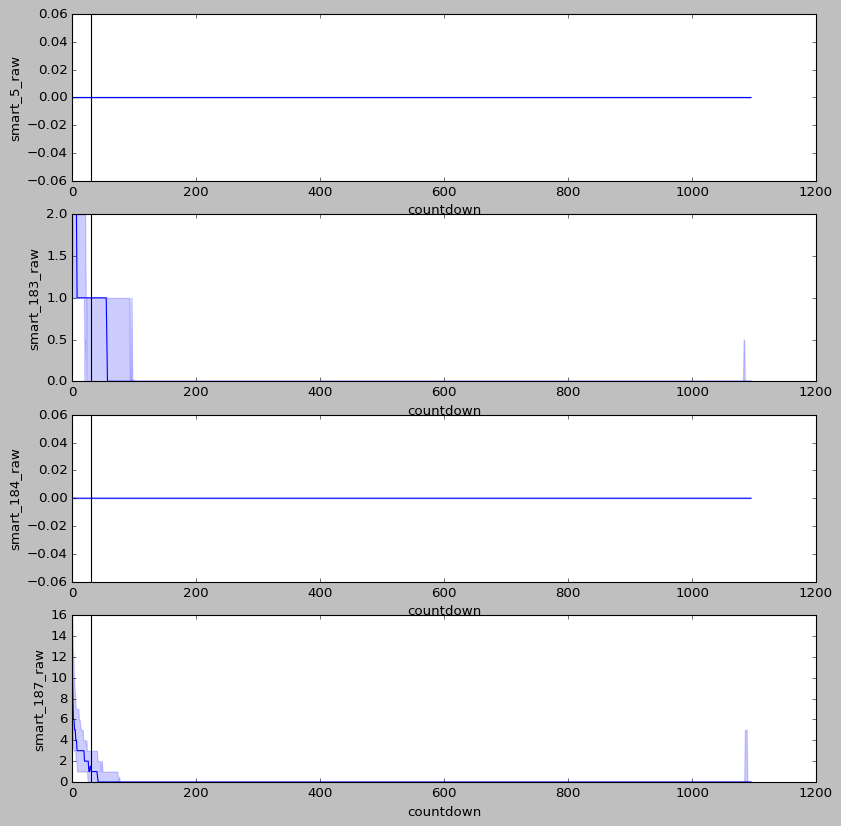

In [6]:
# set the time window (for classification task this is the respective cut off date)
time_window = 30

# plot the important features identified and indicate the time_window
plt.figure(figsize=(12,12))
for num, feat in enumerate(columns):
    plt.subplot(4,1,num+1)
    sns.lineplot(x=df.countdown, y=df[feat], estimator=np.median)
    plt.axvline(x=time_window, c='k')

Smart_183_raw and smart_187_raw seem to be very good indicators. smart_5_raw and smart_184_raw are also good indicators (check mean plots), but only for a small fraction of HDDs.

Towards large values of days_to_fail, we observe some fluctuations. The come from the fact, that we have only very limited statistics available. The number of HDDs in the dataset decreases as a function of days_to_fail, since a rather constant fail rate "takes them out day by day". This can be seen in the following lineplot.

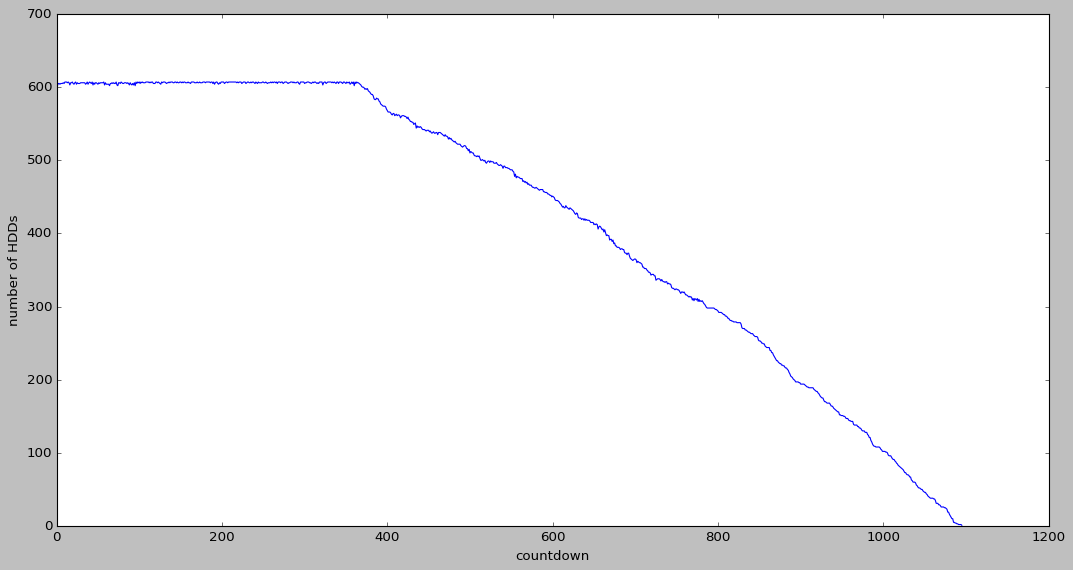

In [7]:
# plot the number of hdds drives over the countdown target
plt.figure(figsize=(16,8))

sns.lineplot(data=df.groupby("countdown").count().date)
plt.ylabel("number of HDDs");

### Train-Test Split

For the first baseline model we take a generic train test split, where we only use stratify to assure that we are having the same proportion of failure and not failure data within both data sets.

In [8]:
# split the data into features and target
X = df[columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED, stratify=y)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

# set the data_split approach for MLFlow communication
data_split = 'stratify on y'

X_train: (347099, 5)
X_test: (115700, 5)
y_train: (347099,)
y_test: (115700,)


In [9]:
# calculate the threshold based on the train data set
df_train = pd.concat([X_train, pd.Series(y_train, name='fail_30')], axis=1)
threshold = df_train[df_train['fail_30'] == 1][columns].median()
threshold

smart_5_raw      0.0
smart_183_raw    1.0
smart_184_raw    0.0
smart_187_raw    3.0
dtype: float64

In [ ]:
# set up MLFlow
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

name = "baseline_model"

# activate MLFlow
mlflow.start_run(run_name=name)
run = mlflow.active_run()

# print run_id
print("Active run_id: {}".format(run.info.run_id))

In [11]:
# set threshold for the baseline model
num_above_threshold = 2

# use the thresholds to calculate the predicted values for the train and test set
y_train_pred = (X_train > threshold).sum(axis=1) > (num_above_threshold-1)
y_test_pred = (X_test > threshold).sum(axis=1) > (num_above_threshold-1)

#### Baseline Model Performance

With this we have now created our first baseline model and in the next part we use the specified metric to look into the model performance.

While we decided on the F2 score (with a higher focus on precision), we still check the different metrics like accuracy, recall and precision, as well as the confusion matrix do understand model performance

##### Train Set Evaluation

Train - F2 score : 0.31
Train - ROC AUC  : 0.66
Train - Recall   : 0.41
Train - Accuracy   : 0.88


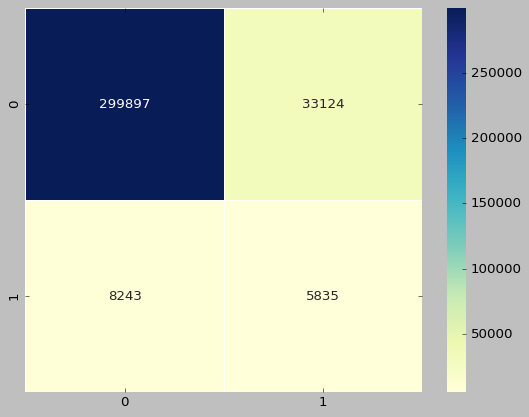

In [12]:
# calculate the training values and save them in the respective variables
fbeta_train = fbeta_score(y_train, y_train_pred, beta=2).round(2)
auc_train = roc_auc_score(y_train, y_train_pred).round(2)
recall_train = recall_score(y_train, y_train_pred).round(2)
accuracy_train = accuracy_score(y_train, y_train_pred).round(2)

# print the training scores
print("Train - F2 score :", fbeta_train)
print("Train - ROC AUC  :", auc_train)
print("Train - Recall   :", recall_train)
print("Train - Accuracy   :", accuracy_train)

# create the confusion matrix
confusion_matrix(y_train, y_train_pred)

# plot the confusion matrix using seaborn
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

##### Test Set Metrics

Test - F2 score : 0.31
Test - ROC AUC  : 0.66
Test - Recall   : 0.42
Test - Accuracy   : 0.88


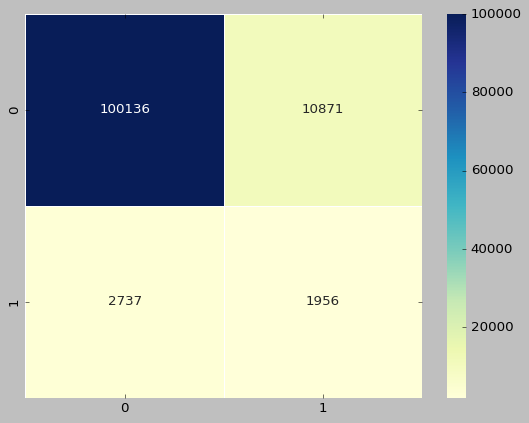

In [13]:
# calculate the training values and save them in the respective variables
fbeta_test = fbeta_score(y_test, y_test_pred, beta=2).round(2)
auc_test = roc_auc_score(y_test, y_test_pred).round(2)
recall_test = recall_score(y_test, y_test_pred).round(2)
accuracy_test = accuracy_score(y_test, y_test_pred).round(2)

# print the training scores
print("Test - F2 score :", fbeta_test)
print("Test - ROC AUC  :", auc_test)
print("Test - Recall   :", recall_test)
print("Test - Accuracy   :", accuracy_test)

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix using seaborn
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

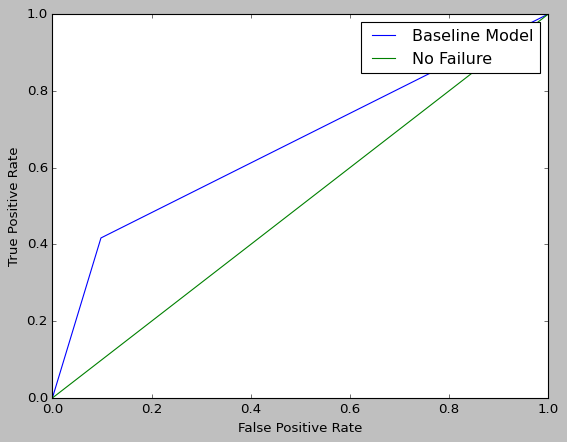

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_pred)
base = np.linspace(0,1,100)
sns.lineplot(fpr, tpr)
sns.lineplot(base, base)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Baseline Model", "No Failure"]);

#### Logging the baseline model performance on MLFlow

In [15]:
# Logging on MLFlow
params = {
      "thresholds": threshold,
      "time_to_fail": time_window,
      "features_above_threshold": num_above_threshold,
      "data_split": data_split
  }

In [ ]:
#logging params to mlflow
mlflow.log_params(params)

#setting tags
mlflow.set_tag("running_from_jupyter", "True")
mlflow.set_tag("model", "Baseline")

#logging metrics
mlflow.log_metric("train_" + "f-2 score", fbeta_train)
mlflow.log_metric("test_" + "f-2 score", fbeta_test)

# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")

mlflow.end_run()

## Baseline Model 2

As we are working with sequential data another approach for the train test split is to divide the data alongside the serial_numbers. This way we can assure that we do not split the serial_numbers into the train and test split and does interrupt the sequential data.  

Even as we are currently not treating this as a time series analysis, we have sequential data which might profit from this splitting approach.

#### Splitting the data

In [3]:
# create a helper column containing the features we want to use for plotting
columns = ['serial_number']

for col in df.columns:
    if '5' in col or '183' in col or '184' in col or '187' in col:
        if 'raw' in col:
            columns.append(col)

In [6]:
# split the data into features and target
X = df[columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (322152, 4)
X_test: (140647, 4)
y_train: (322152,)
y_test: (140647,)


#### Setting up the MLFlow connection

Next we again set up the MLFlow for the second baseline model. We use the same hyperparameter, but choose a different train test split, so we also track this with a separate parameter.

In [ ]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

# define the run name 
name = "baseline_model" + datetime.now()

# start MLFlow 
mlflow.start_run(run_name=name)
run = mlflow.active_run()

# print the run_id
print("Active run_id: {}".format(run.info.run_id))

#### Calculating the baseline model

In [ ]:
# set threshold for the baseline model
num_above_threshold = 2

# use the thresholds to calculate the predicted values for the train and test set
y_train_pred = (X_train > threshold).sum(axis=1) > (num_above_threshold-1)
y_test_pred = (X_test > threshold).sum(axis=1) > (num_above_threshold-1)

#### Baseline Model Performance

##### Train Set Evaluation

Train - F2 score : 0.31
Train - ROC AUC  : 0.66
Train - Recall   : 0.41
Train - Accuracy : 0.88


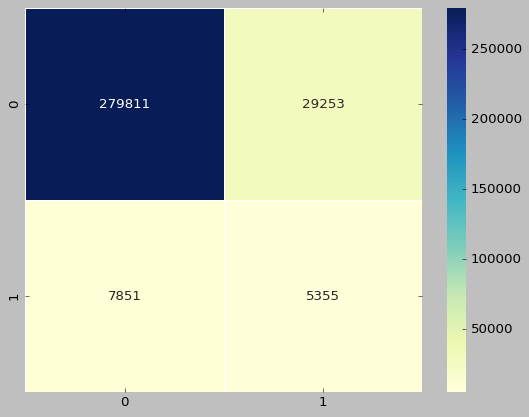

In [23]:
# calculate the training values and save them in the respective variables
fbeta_train = fbeta_score(y_train, y_train_pred, beta=2).round(2)
auc_train = roc_auc_score(y_train, y_train_pred).round(2)
recall_train = recall_score(y_train, y_train_pred).round(2)
accuracy_train = accuracy_score(y_train, y_train_pred).round(2)

# print the training scores
print("Train - F2 score :", fbeta_train)
print("Train - ROC AUC  :", auc_train)
print("Train - Recall   :", recall_train)
print("Train - Accuracy :", accuracy_train)

# create the confusion matrix
confusion_matrix(y_train, y_train_pred)

# plot the confusion matrix using seaborn
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

##### Test Set Evaluation

Test - F2 score : 0.31
Test - ROC AUC  : 0.66
Test - Recall   : 0.44
Test - Accuracy   : 0.87


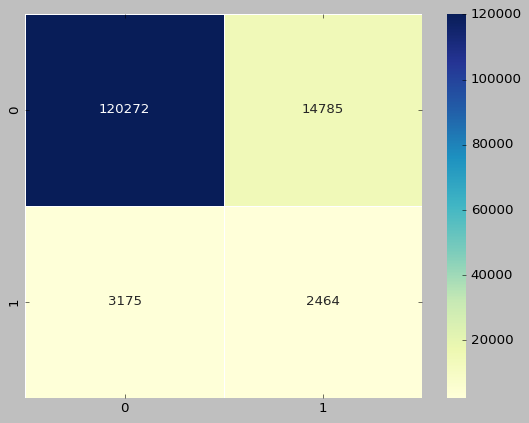

In [24]:
# calculate the test values and save them in the respective variables
fbeta_test = fbeta_score(y_test, y_test_pred, beta=2).round(2)
auc_test = roc_auc_score(y_test, y_test_pred).round(2)
recall_test = recall_score(y_test, y_test_pred).round(2)
accuracy_test = accuracy_score(y_test, y_test_pred).round(2)

# print the test scores
print("Test - F2 score :", fbeta_test)
print("Test - ROC AUC  :", auc_test)
print("Test - Recall   :", recall_test)
print("Test - Accuracy   :", accuracy_test)

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix using seaborn
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

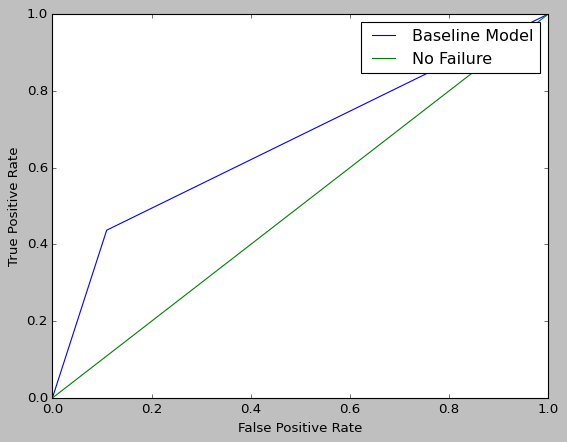

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_pred)
base = np.linspace(0,1,100)
sns.lineplot(fpr, tpr)
sns.lineplot(base, base)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Baseline Model", "No Failure"]);

#### Logging the baseline model performance on MLFlow

In [26]:
# Logging on MLFlow
params = {
      "thresholds": threshold,
      "time_to_fail": time_window,
      "features_above_threshold": num_above_threshold,
      "data_split": data_split
  }

In [ ]:
#logging params to mlflow
mlflow.log_params(params)

#setting tags
mlflow.set_tag("running_from_jupyter", "True")
mlflow.set_tag("model", "Baseline")

#logging metrics
mlflow.log_metric("train_" + "f-2 score", fbeta_train)
mlflow.log_metric("test_" + "f-2 score", fbeta_test)

# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")

mlflow.end_run()

The two baseline models were used to identify if the split based on stratify is enough or if we can achieve higher results based on avoiding splits of the serial numbers. As both approaches deem the same result, we continue splitting the data solely on the 'stratify=y' approach.

## DecisionTreeClassifier

After designing our baseline model, we train a model using similar features (5, 183, 184, 187) and feed a decision tree and a random forest with this data.

Based on this outcome we look into other relevant columns, potential feature engineering, etc.

While we already have a train test split in place that would fullfil the requirements, we create a new train test split using the normal stratify parameter.

In [9]:
# split the data into features and target
X = df[columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (322152, 4)
X_test: (140647, 4)
y_train: (322152,)
y_test: (140647,)


In [10]:
# instantiating the tree classifier and training it on the train data
tree = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

Scores:
-------------------------
ROC-AUC : 0.5785
Accuracy : 0.9418
Recall   : 0.1837
Precision: 0.2231
F1 Score: 0.2015
F2 Score : 0.1904


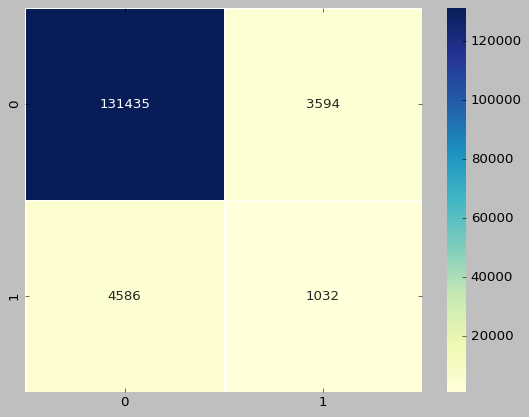

In [11]:
# create the predictions using the previously trained model
y_test_pred = tree.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

The simple decision tree with only the four features 5, 183,184, 187 without any additional hyperparameter tuning performs not as good as our baseline model. 

Still it might give valuable information to look into the feature importance, to understand which features had a higher relevance for splitting the nodes.

### Feature Importance

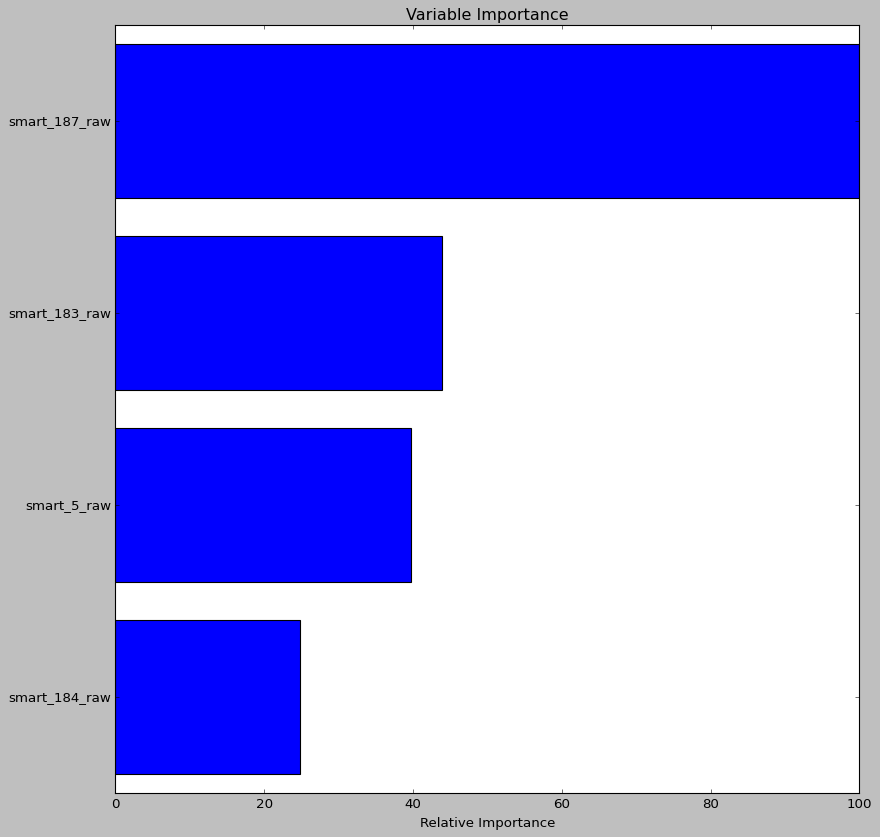

In [12]:
# plot feature importance
feature_importance = tree.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The simple tree puts the highest importance on the 187 feature. Let us look into the random forest to understand if the other classifier also puts the same importance on these four features.

## RandomForestClassifier

Next we try a generic Random Forest Classifier and see how well this machine learning algorithm handles the data and see how well it performs in comparison to the baseline model and the single decision tree.

As we already have a train test split created for the decision tree, we will use the same train test split and still limit ourselves to the four features selected (5, 183, 184, 187).

In [13]:
# check on the training data to make sure that we have the correct features selected
X_train.head()

,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
1,0.0,5.0,0.0,5.0
3,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0
5,0.0,3.0,0.0,14.0
7,0.0,2.0,0.0,12.0


Scores:
-------------------------
ROC-AUC : 0.5836
Accuracy : 0.9340
Recall   : 0.2027
Precision: 0.1918
F1 Score: 0.1971
F2 Score : 0.2004


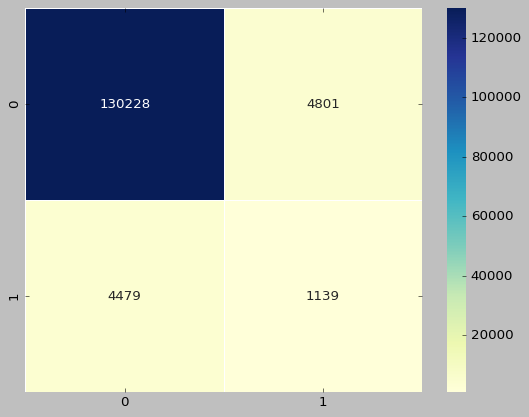

In [17]:
from sklearn.ensemble import RandomForestClassifier

# instantiate and train the model
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

# predict the target variable using the trained model
y_test_pred = forest.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Next we look at the feature importance for the Random Forest Classifier.

#### Feature Importance

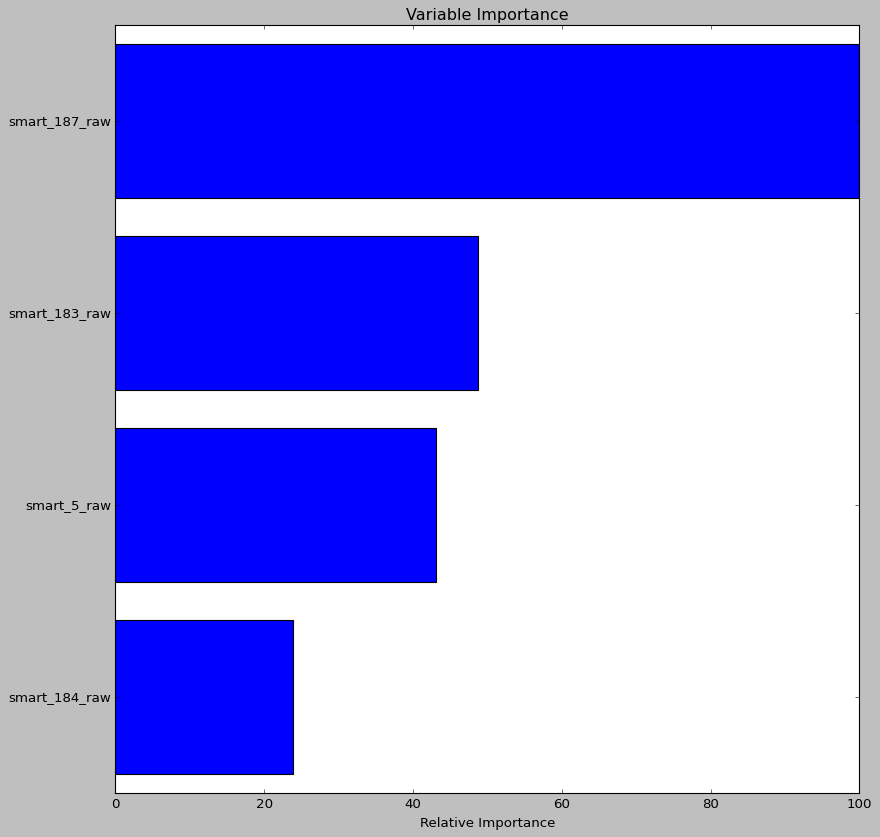

In [18]:
# Plot feature importance
feature_importance = forest.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

While both models put the highest emphasize on the smart_187_raw feature. The second and third feature have a different order for the decision tree and random forest. Random Forest puts a higher importance on the smart_5_raw while in comparison treats the smart_183_raw as a more important feature.

### Improving our models

Next, we see if our decision tree classifier or random forest classifier performs better if we add additional features to it. As of know we have not used any time/age related features, but as they might be relevant for the failure, we use some of them within the next approach.

First we select the 9th feature which is indicating the run-time of the hdd as well as the 240th feature.

In [21]:
# create a helper column containing the features we want to use for plotting
columns = ['serial_number']

for col in df.columns:
    if '5' in col or '_9_' in col or '183' in col or '184' in col or '187' in col or '240' in col:
        if 'raw' in col:
            columns.append(col)

In [22]:
# split the data into features and target
X = df[columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (322152, 6)
X_test: (140647, 6)
y_train: (322152,)
y_test: (140647,)


## Decision Tree Upgraded

In [23]:
# instantiate and train the model
tree_check = DecisionTreeClassifier()
tree_check.fit(X_train, y_train)

DecisionTreeClassifier()

Scores:
-------------------------
ROC-AUC : 0.6163
Accuracy : 0.9221
Recall   : 0.2841
Precision: 0.1870
F1 Score: 0.2255
F2 Score : 0.2574


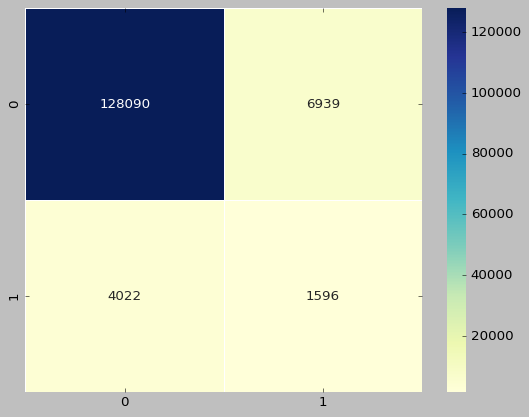

In [24]:
# create the predictions using the previously trained model
y_test_pred = tree_check.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

This two features seem to have a very high relevance for that data set, as the metrics improved quiet a bit in comparison of the last classification model, where we only took the 4 features from the baseline model.

#### Feature Importance

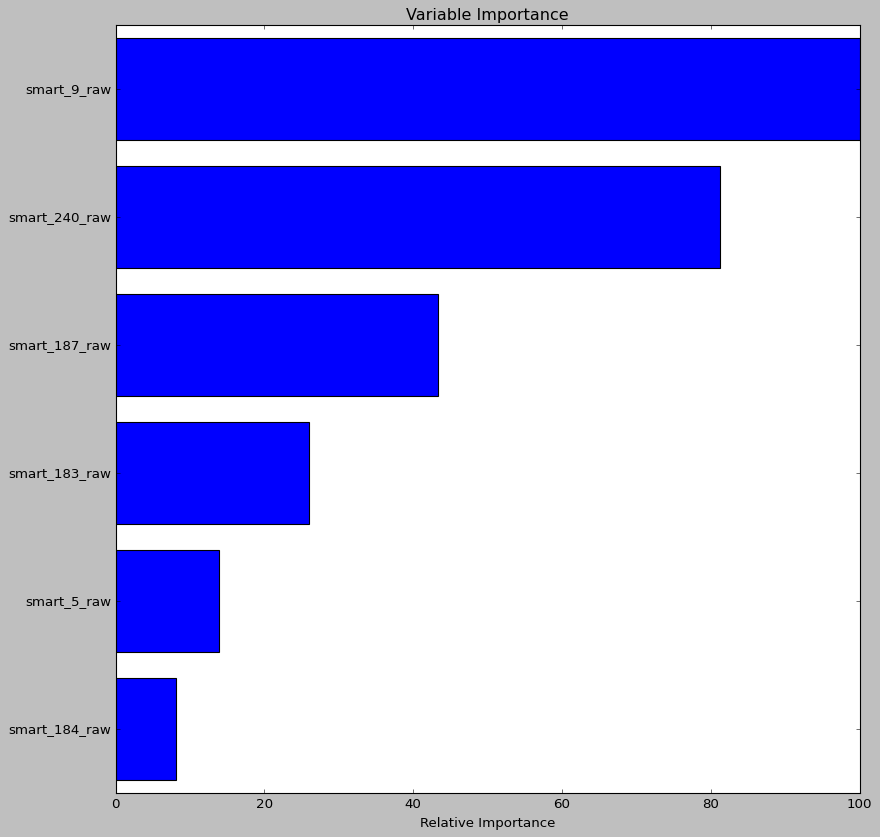

In [25]:
# Plot feature importance
feature_importance = tree_check.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As expected after the result, the model is placing a high importance on the added two features. Next we try to apply this same data set to the Random Forest Classifier and see what the outcome of this one is.

## RandomForest Upgraded

In [26]:
# instantiate and train the model
forest_check = RandomForestClassifier()
forest_check.fit(X_train, y_train)

# create the predictions using the previously trained model
y_test_pred = forest_check.predict(X_test)

Scores:
-------------------------
ROC-AUC : 0.6043
Accuracy : 0.9400
Recall   : 0.2394
Precision: 0.2440
F1 Score: 0.2417
F2 Score : 0.2403


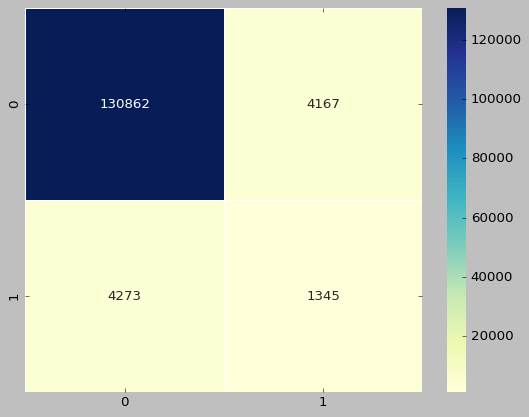

In [27]:
# create the predictions using the previously trained model
y_test_pred = forest_check.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

As we can see adding the new features 9 and 240 already causes a significant improvement over the previously trained model using only 5, 183, 184, 187.

Thus, as a next attempt for the classification task, we add all raw data into the classifier and see how well this improves the output and which features are deemed important. The additional features will both be tested on the Decision Tree as well as on the Random Forest Classifier.

In [29]:
# create a helper column containing the features we want to use for plotting
raw_columns = ['serial_number']

for col in df.columns:
    if 'raw' in col:
        raw_columns.append(col)

In [30]:
# split the data into features and target
X = df[raw_columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (322152, 21)
X_test: (140647, 21)
y_train: (322152,)
y_test: (140647,)


## Decision Tree Second Upgrade

In [31]:
# instantiate and train the model
tree_raw = DecisionTreeClassifier()
tree_raw.fit(X_train, y_train)

DecisionTreeClassifier()

Scores:
-------------------------
ROC-AUC : 0.6208
Accuracy : 0.9090
Recall   : 0.3076
Precision: 0.1624
F1 Score: 0.2126
F2 Score : 0.2609


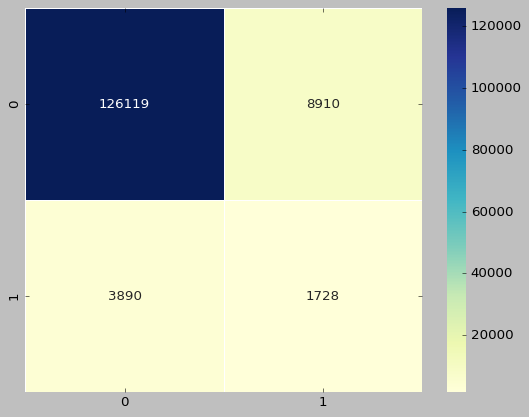

In [32]:
# create the predictions using the previously trained model
y_test_pred = tree_raw.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Using all the raw data for the training has a very positive effect on the metric and we will make a comparison for the Random Forest before adapting the features again. However, we definitely look into the feature importance and see if we can and should reduce the features used.

#### Feature Importance

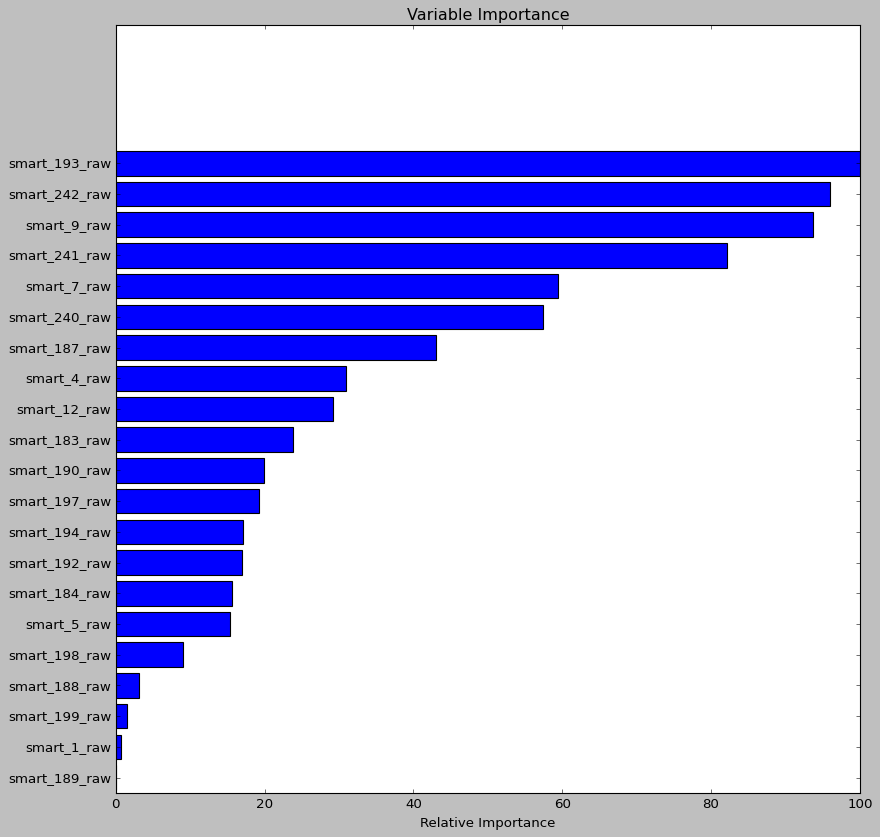

In [33]:
# plot feature importance
feature_importance = tree_raw.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In comparison to our baseline model the focus lies on other features. Especially 193, 242, 9 and 241 are very important for the Decision Tree to perform well.

Next we apply the Random Forest on the same features.

## RandomForest Second Upgrade

In [34]:
# instantiate and train the model
forest_raw = RandomForestClassifier()
forest_raw.fit(X_train, y_train)

RandomForestClassifier()

Scores:
-------------------------
ROC-AUC : 0.6214
Accuracy : 0.9465
Recall   : 0.2681
Precision: 0.3063
F1 Score: 0.2859
F2 Score : 0.2749


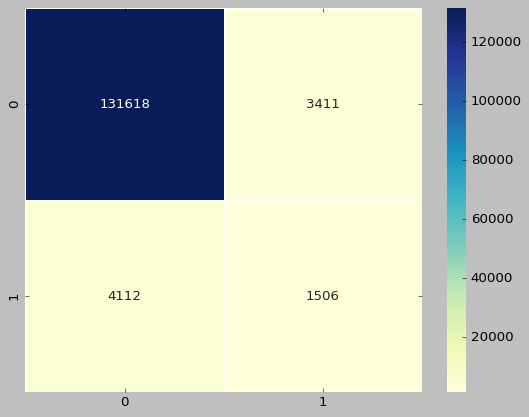

In [35]:
# predict the target variable using the trained model
y_test_pred = forest_raw.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

The Random Forest outperforms the Decision Tree again slightly (as expected), but comes to somewhat similar results.


#### Feature Importance

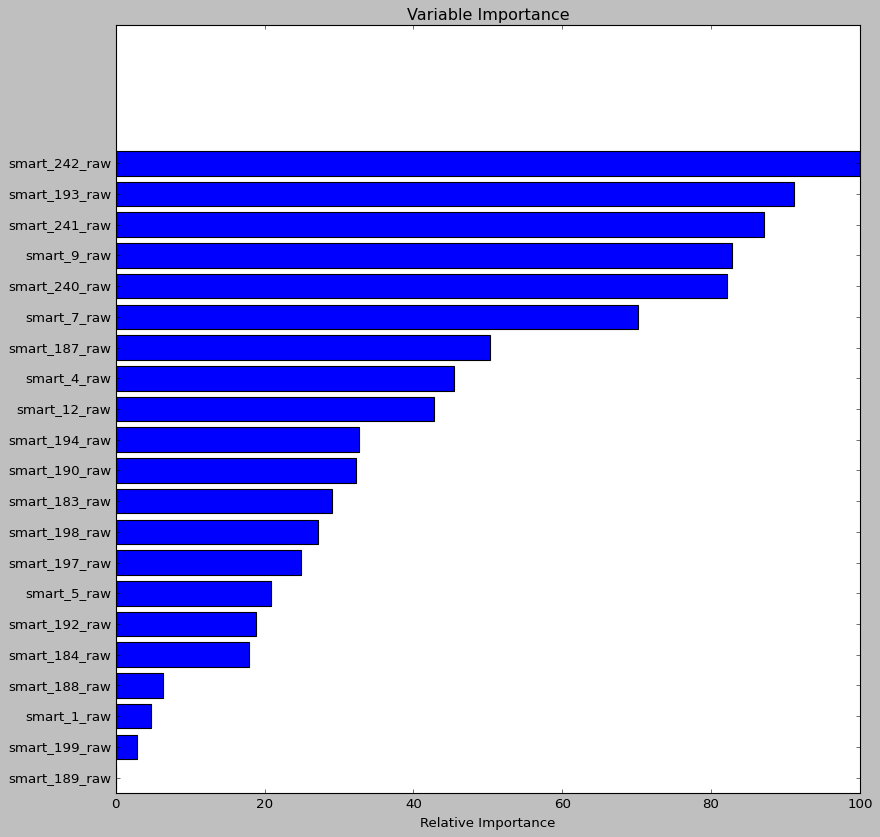

In [36]:
# Plot feature importance
feature_importance = forest_raw.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

While the same features are in the Top 5 of the feature importance, some of them have a higher value for the Random Forest Classifier in comparison to the Decision Tree Classifier.

We definitely can see a bit about feature engineering in terms of combining some feature to a score (e.g. a time related score taking into account all time/age related features) to reduce the amount of features used and see how well our model performs with that.

However, beforehand we are going to look into the possibility of turing our classification task into a regression task.

As we already had a countdown established that was indicating how long a hard drive was still functional at any point in time within our data set, we use this as the new target variable.

## Regression model

As the Tree based models worked very well for that data for the classification task, we use a tree based model also for attempting the regression task.

For the beginning we try out the decision tree and random forest and see afterwards if we want to boost our tree some more.

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [40]:
# create a helper column containing the features we want to use for plotting
columns = ['serial_number']

for col in df.columns:
    if '5' in col or '183' in col or '184' in col or '187' in col:
        if 'raw' in col:
            columns.append(col)

We start by training a Decision Tree Regressor also only using the basic features used in the basic classification task (e.g. only using the small amount of features selected).

In [41]:
# split the data into features and target
X = df[columns]
y = df.countdown

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (322152, 4)
X_test: (140647, 4)
y_train: (322152,)
y_test: (140647,)


In [42]:
# instantiate and train the model
tree_simple = DecisionTreeRegressor()
tree_simple.fit(X_train, y_train)

# create the predictions using the previously trained model
y_test_pred = tree_simple.predict(X_test)

# calculate the relevant metrics for the model
rmse = mean_squared_error(y_test, y_test_pred)
print(f'RMSE: {(np.sqrt(rmse)).round(2)}')

RMSE: 253.71


While the RMSE is not that high, the result is definitely not great. Thus, we are not going to train a RandomForest using that data, but already extent our features a bit, using feature 9 and 240 (similar to our classification tree)

In [43]:
# create a helper column containing the features we want to use for plotting
columns = ['serial_number']

for col in df.columns:
    if '5' in col or '_9_' in col or '183' in col or '184' in col or '187' in col or '240' in col:
        if 'raw' in col:
            columns.append(col)

In [44]:
# split the data into features and target
X = df[columns]
y = df.countdown

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (322152, 6)
X_test: (140647, 6)
y_train: (322152,)
y_test: (140647,)


In [45]:
# instantiate and train the model
tree_check = DecisionTreeRegressor()
tree_check.fit(X_train, y_train)

# create the predictions using the previously trained model
y_test_pred = tree_check.predict(X_test)

# calculate the relevant metrics for the model
rmse = mean_squared_error(y_test, y_test_pred)
print(f'RMSE: {(np.sqrt(rmse)).round(2)}')

RMSE: 267.24


It actually seems that our extra features did not improve the result at all, but rather slightly increased the RMSE.

To check how our model behaves with more features, we are going to hand the whole raw features to the decision tree and will cross check this with a RandomForest Regressor as well.

In [47]:
# create a helper column containing the features we want to use for plotting
raw_columns = ['serial_number']

for col in df.columns:
    if 'raw' in col:
        raw_columns.append(col)

In [48]:
# split the data into features and target
X = df[raw_columns]
y = df.countdown

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (322152, 21)
X_test: (140647, 21)
y_train: (322152,)
y_test: (140647,)


In [49]:
# instantiate and train the model
tree_raw = DecisionTreeRegressor(min_samples_leaf=200)
tree_raw.fit(X_train, y_train)

# create the predictions using the previously trained model
y_test_pred = tree_raw.predict(X_test)

# calculate the relevant metrics for the model
rmse = mean_squared_error(y_test, y_test_pred)
print(f'RMSE: {(np.sqrt(rmse)).round(2)}')

RMSE: 226.7


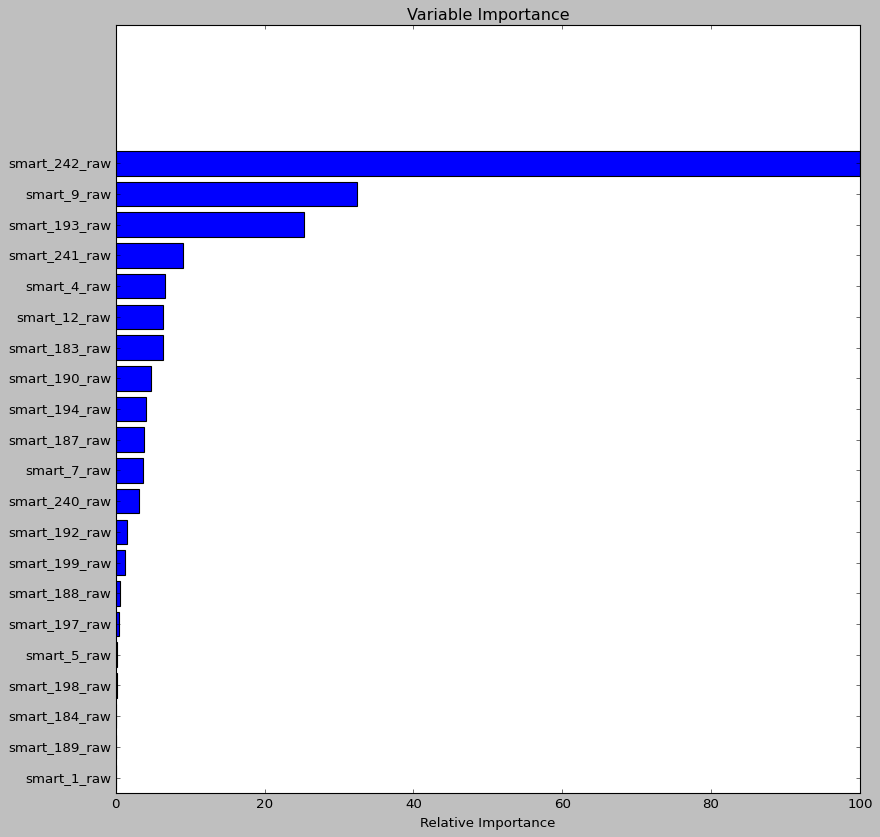

In [50]:
# Plot feature importance
feature_importance = tree_raw.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The decision tree for regression has still quiet a big RMSE even though we used all raw features available in the data set, which had quiet a good result for the classification tasks.

However, following our previous approach, we also train a Random Forest Regressor and see how well this model performs with additional features.

In [51]:
# instantiate and train the model
forest_raw = RandomForestRegressor()
forest_raw.fit(X_train, y_train)

# create the predictions using the previously trained model
y_test_pred = forest_raw.predict(X_test)

# calculate the relevant metrics for the model
rmse = mean_squared_error(y_test, y_test_pred)
print(f'RMSE: {(np.sqrt(rmse)).round(2)}')

RMSE: 210.6


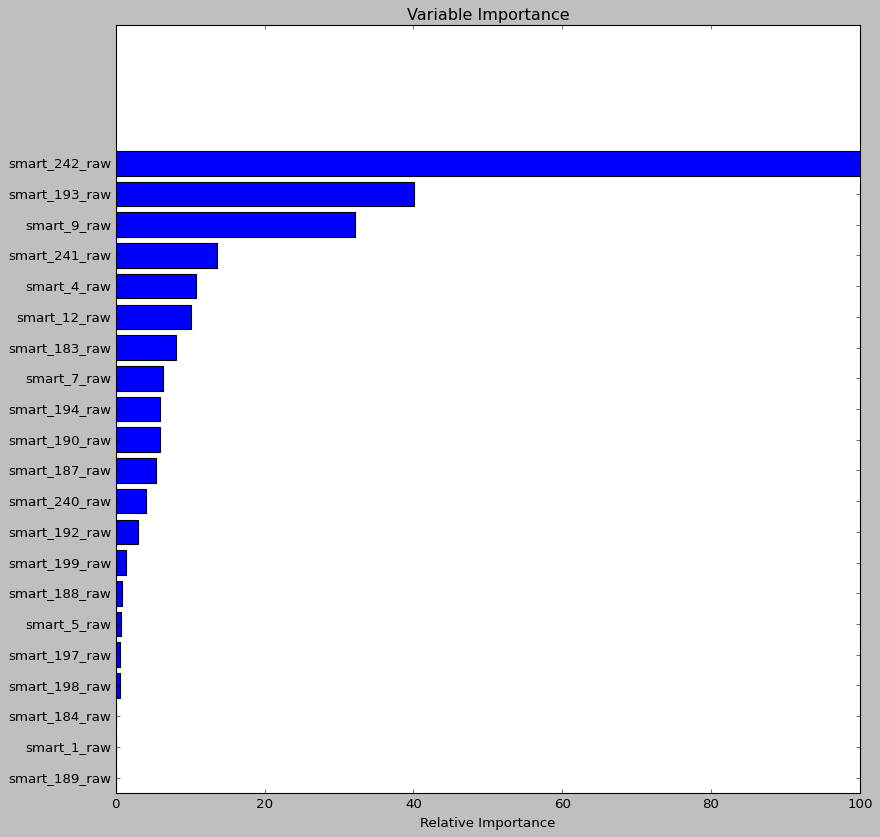

In [52]:
# Plot feature importance
feature_importance = forest_raw.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [53]:
# create a data frame containing the true values and the predicted values for comparison and residual plot
results = pd.concat([pd.Series(y_test, name='true').reset_index(), pd.Series(y_test_pred, name='predicted').reset_index().drop(['index'], axis=1)], axis=1)
results.set_index('index', inplace=True)
results['residuals'] = results.true - results.predicted

In [54]:
results

,true,predicted,residuals
index,,,
0,50,312.03,-262.03
2,252,163.19,88.81
6,327,194.84,132.16
9,348,365.78,-17.78
10,43,270.78,-227.78
...,...,...,...
463072,440,328.36,111.64
463073,36,3.30,32.70
463080,379,80.91,298.09


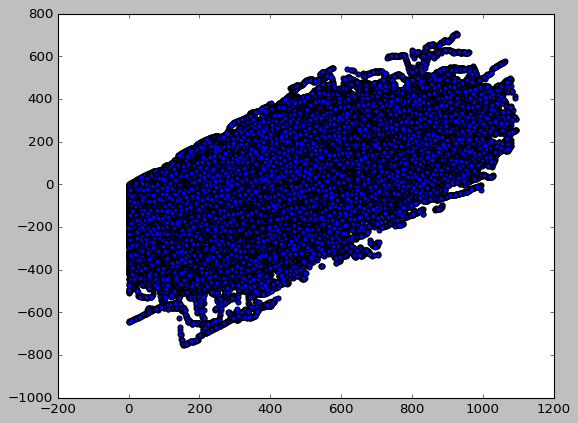

In [55]:
plt.scatter(results.true, results.residuals)

## Logistic Regression with PCA

In [5]:
# create a helper column containing the features we want to use for plotting
raw_columns = ['serial_number']

for col in df.columns:
    if 'raw' in col:
        raw_columns.append(col)

In [6]:
# split the data into features and target
X = df[raw_columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (322152, 21)
X_test: (140647, 21)
y_train: (322152,)
y_test: (140647,)


In [7]:
# instantiate scaler
scaler = MinMaxScaler()

# fit on train and transform train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# instantiate PCA
pca_ = PCA(0.95, random_state=RSEED)
X_train_pca = pca_.fit_transform(X_train)
X_test_pca = pca_.transform(X_test)

In [8]:
log_reg = LogisticRegression()

log_reg.fit(X_train_pca, y_train)
y_test_pred = log_reg.predict(X_test_pca)

Scores:
-------------------------
ROC-AUC : 0.5000
Accuracy : 0.0399
Recall   : 1.0000
Precision: 0.0399
F1 Score: 0.0768
F2 Score : 0.1722


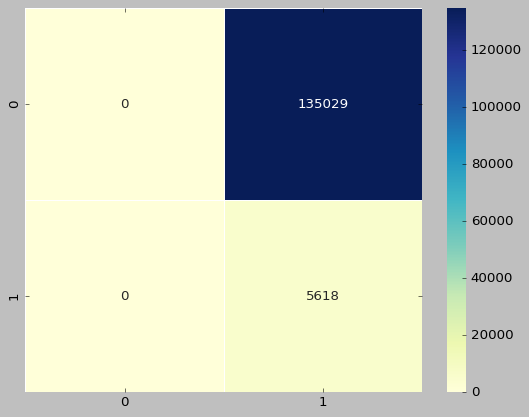

In [9]:
# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [75]:
param_grid = {"solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              "max_iter" : [100, 1000],
              "penalty" : ["l2", "l1", "none", "elasticnet"],
              "tol": [0.0001, 0.001, 0.01, 0.1, 1.0]
             }

log_reg = LogisticRegression()

gs_log = GridSearchCV(log_reg, param_grid, scoring='f1',
                  cv=5, verbose=1, n_jobs=-1)

gs_log.fit(X_train_scaled, y_train)

Scores:
-------------------------
ROC-AUC : 0.5435
Accuracy : 0.9552
Recall   : 0.0961
Precision: 0.3068
F1 Score: 0.1464
F2 Score : 0.1114


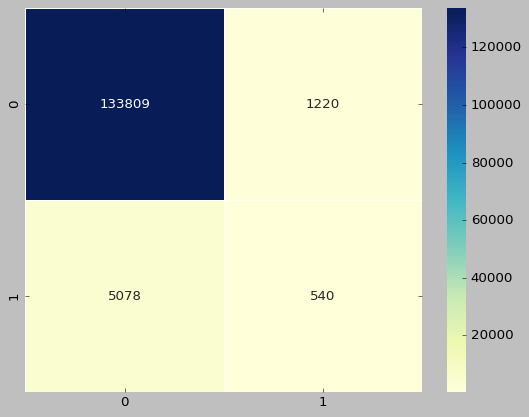

In [79]:
# Best score
print('Best score:', round(gs_log.best_score_, 3))

# Best parameters
print('Best parameters:', gs_log.best_params_)

y_test_pred = gs_log.predict(X_test_scaled)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Anomaly Detection

In [3]:
from sklearn.neighbors import LocalOutlierFactor

In [48]:
train_data = df.query('failure == 0')
test_data = df.query('failure == 1')

In [49]:
# create a helper column containing the features we want to use for plotting
raw_columns = []

for col in df.columns:
    if 'raw' in col:
        raw_columns.append(col)

In [50]:
train_data = train_data[raw_columns]
train_data = train_data[:100000]
test_data = test_data[raw_columns]
train_data

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,93783288.0,13.0,0.0,208544989.0,42390.0,13.0,0.0,0.0,0.0,0.0,...,22.0,0.0,6846.0,22.0,0.0,0.0,0.0,42329.0,5.519570e+10,2.709359e+11
1,55185864.0,13.0,0.0,586510565.0,42857.0,13.0,5.0,0.0,5.0,0.0,...,25.0,0.0,10166.0,25.0,16.0,16.0,0.0,42778.0,5.982921e+10,2.557590e+11
2,170426904.0,6.0,0.0,639460780.0,46828.0,6.0,0.0,0.0,1.0,0.0,...,21.0,0.0,38881.0,21.0,16.0,16.0,0.0,46671.0,6.363719e+10,2.580255e+11
3,119029336.0,27.0,0.0,615938251.0,44034.0,27.0,0.0,0.0,0.0,0.0,...,29.0,2.0,12051.0,29.0,0.0,0.0,0.0,43845.0,6.252935e+10,2.568232e+11
4,18778216.0,8.0,0.0,587606218.0,44474.0,8.0,2.0,0.0,0.0,24.0,...,29.0,0.0,21038.0,29.0,0.0,0.0,57.0,44350.0,6.250835e+10,2.357636e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100202,44457560.0,10.0,0.0,339189425.0,35218.0,9.0,0.0,0.0,0.0,0.0,...,21.0,0.0,137948.0,21.0,0.0,0.0,0.0,34390.0,3.691031e+10,1.947969e+11
100203,137528208.0,5.0,0.0,876469786.0,35414.0,5.0,0.0,0.0,0.0,0.0,...,20.0,1.0,10424.0,20.0,0.0,0.0,0.0,35250.0,5.335049e+10,1.756926e+11
100204,175134552.0,5.0,1896.0,736435356.0,33696.0,5.0,0.0,0.0,2.0,0.0,...,25.0,0.0,5534.0,25.0,0.0,0.0,0.0,33604.0,5.140694e+10,1.587307e+11
100205,38558384.0,14.0,0.0,852333131.0,35912.0,14.0,2.0,0.0,0.0,0.0,...,24.0,0.0,6592.0,24.0,0.0,0.0,0.0,35849.0,5.538272e+10,1.669148e+11


In [51]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

In [52]:
anomaly = LocalOutlierFactor(novelty=True)
anomaly.fit(X_train)

LocalOutlierFactor(novelty=True)

In [53]:
# create the predictions using the previously trained model
y_test_pred = anomaly.predict(X_test)
y_test_pred